## Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from data import ParenthesizationDataset, parenthesization_to_tensor, padding_mask
from model import Model
from train import train_one_epoch, compute_validation_loss
from evaluate import evaluate_model, predict
from interpret import plot_linear_layer, incorrect_predictions, token_contributions, activations
import matplotlib.pyplot as plt

## Initialize model, loaders, loss function, optimizer
`checkpoint_epochs` is the number of epochs before a checkpoint is saved. Use `data_prefix` to choose the "small" dataset.

In [2]:
epochs = 20
checkpoint_epochs = 2
batch_size = 64 # larger: increases accuracy (?) and speed
d_model = 16 # may be 4, 8, or 16
nhead = 4 # must divide d_model
num_layers = 1
n_vocab = 4
data_prefix = "" # remove for full dataset

training_dataset = ParenthesizationDataset(f"{data_prefix}training")
validation_dataset = ParenthesizationDataset(f"{data_prefix}validation")
test_dataset = ParenthesizationDataset(f"{data_prefix}test")

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = Model(n_vocab, d_model, nhead, num_layers)
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train model
`start_epoch` can be set to a value greater than 0 to resume training from a checkpoint.

In [3]:
start_epoch = 19

training_loss = []
validation_loss = []
best_validation_loss = float("inf")

def save():
    torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'training_loss': training_loss,
      'validation_loss': validation_loss
    }, f"checkpoints/epoch_{epoch}.pth")

def resume(epoch):
    global training_loss, validation_loss
    checkpoint = torch.load(f"checkpoints/epoch_{epoch}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    training_loss = checkpoint["training_loss"]
    validation_loss = checkpoint["validation_loss"]

if start_epoch > 0:
    resume(start_epoch)
    start_epoch += 1

for epoch in range(start_epoch, epochs):
    model.train(True)
    training_loss.append(train_one_epoch(training_loader, model, loss_fn, optimizer))
    validation_loss.append(compute_validation_loss(validation_loader, model, loss_fn))
    print(f"Epoch {epoch}, Training Loss {training_loss[-1]}, Validation Loss {validation_loss[-1]}")

    if (epoch+1) % checkpoint_epochs == 0:
        save()

# Plot the loss curve for training and validation

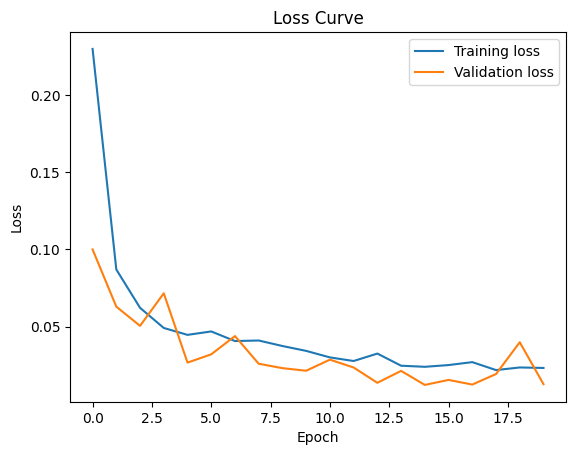

In [4]:
# Plot loss function
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# Evaluate the model and plot the confusion matrix

C:\Users\lewil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ..\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training data set accuracy:
Accuracy for class 0 = 99.01057607806297%
Accuracy for class 1 = 100.0%
Overall accuracy = 99.50529178693455%


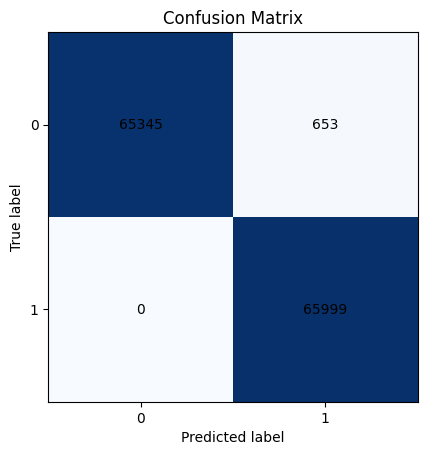

Validation data set accuracy:
Accuracy for class 0 = 99.36954413191077%
Accuracy for class 1 = 100.0%
Overall accuracy = 99.68477206595539%


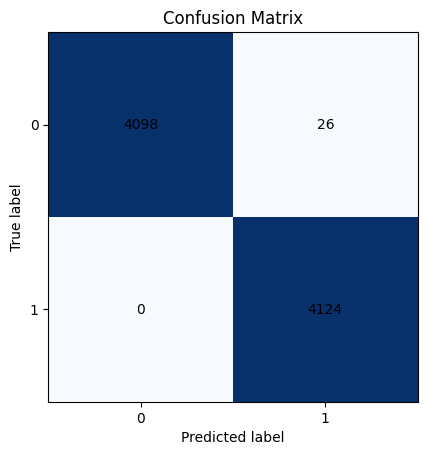

Test data set accuracy:
Accuracy for class 0 = 99.14336512041378%
Accuracy for class 1 = 100.0%
Overall accuracy = 99.57168256020688%


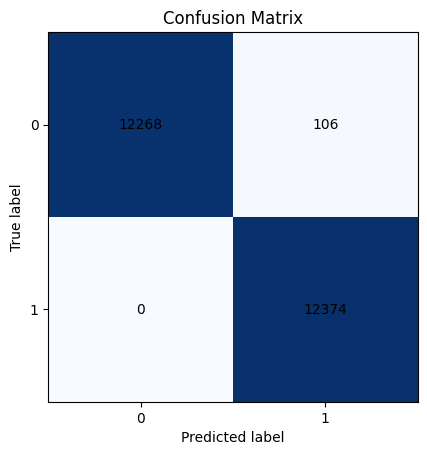

In [5]:
training_confusion_matrix = evaluate_model(model, training_loader)
validation_confusion_matrix = evaluate_model(model, validation_loader)
test_confusion_matrix = evaluate_model(model, test_loader)

print("Training data set accuracy:")
training_confusion_matrix.print_accuracy()
training_confusion_matrix.plot()

print("Validation data set accuracy:")
validation_confusion_matrix.print_accuracy()
validation_confusion_matrix.plot()

print("Test data set accuracy:")
test_confusion_matrix.print_accuracy()
test_confusion_matrix.plot()

# Interpretation
In this section you will try various techniques to interpret the model. Insert additional notebook cells as needed to do the following:

1. Construct some test cases of varying lengths and display the model's predictions.
2. Compute the list of incorrect predictions and display some examples of them.
3. For each incorrect prediction, plot the token contributions as a heatmap.
4. For each position from 0 to 21, loop over all inputs in the test set and plot a histogram of the token contributions for that position.
5. Plot the heatmap for the projection layer and the second linear layer in the feedforward.
6. Loop over all inputs in the test set and count the activations in the feedforward layer. Plot the activations as a histogram to see which features in the feedforward layer are activated the most.


Part 1:
Input: (((((((())))))))
Output: 1

Input: (()(()))()
Output: 1

Input: )()(()())
Output: 0

Input: (())()((()(()))
Output: 1


Part 2:
Input: tensor([2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
Output: 1
Target: 0

Input: tensor([2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
Output: 1
Target: 0

Input: tensor([2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
Output: 1
Target: 0

Input: tensor([2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
Output: 1
Target: 0

Input: tensor([2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
Output: 1
Target: 0


Part 3:


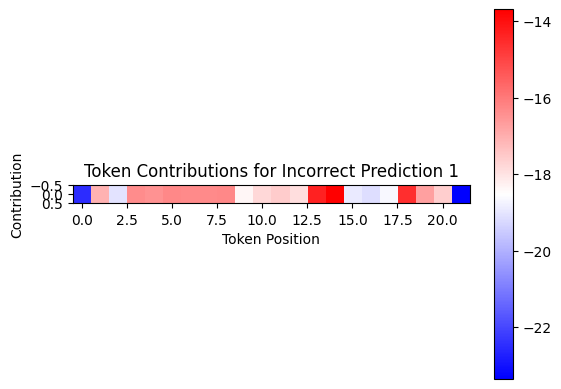

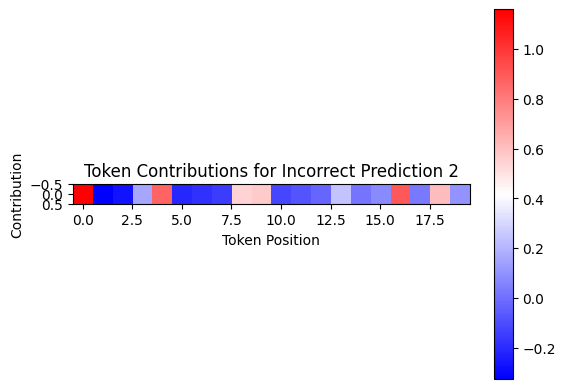

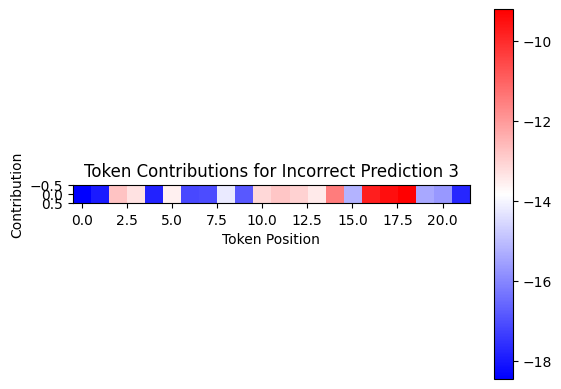

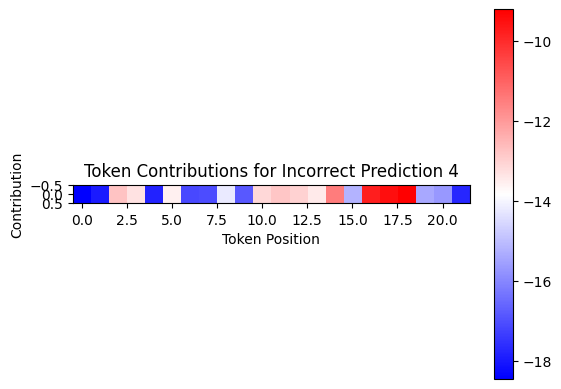

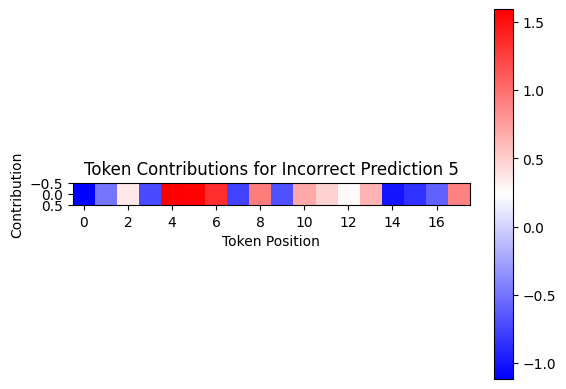


Part 4:

Part 5:


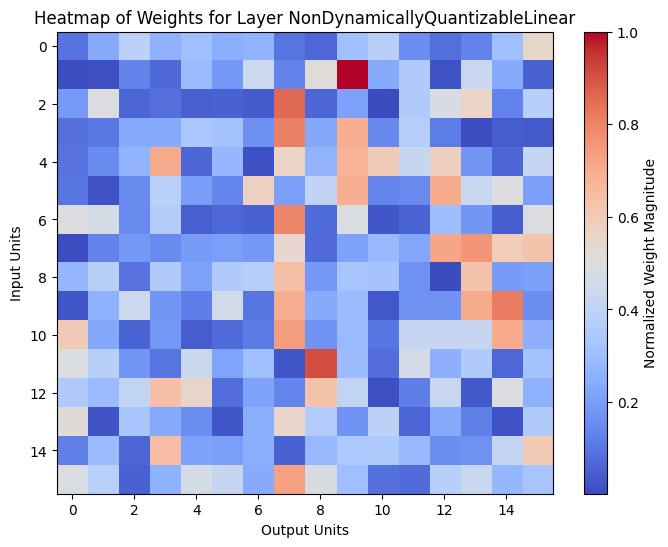

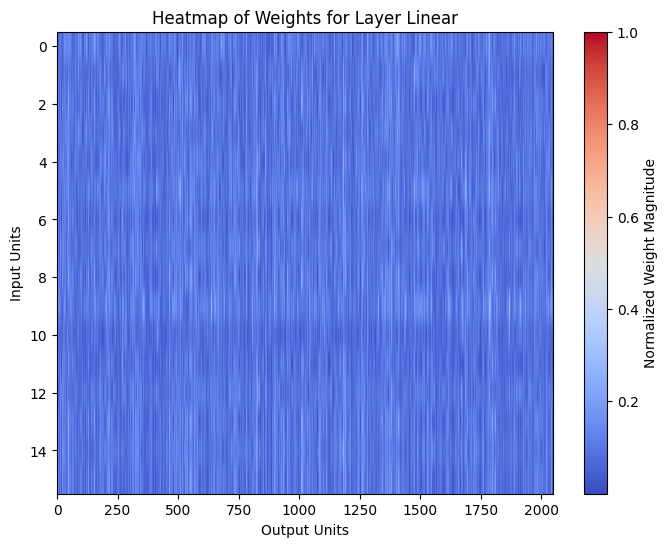


Part 6:


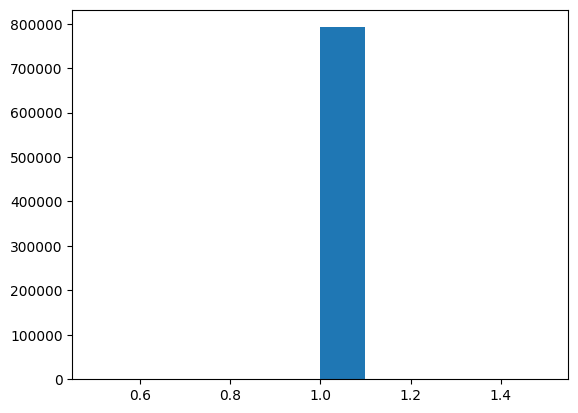

In [6]:
"""test2_dataset = ParenthesizationDataset(f"{data_prefix}test2")
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)
test2_confusion_matrix = evaluate_model(model, test2_loader)
print("Test2 data set accuracy:")
test2_confusion_matrix.print_accuracy()
test2_confusion_matrix.plot()"""

print() 
print("Part 1:")

test2_parenthesizations = ['(((((((())))))))', '(()(()))()', ')()(()())', '(())()((()(()))'] # valid, valid, invalid, invalid (final invalid case made to be difficult)

for parenthesization in test2_parenthesizations:
    print(f"Input: {parenthesization}")
    print(f"Output: {predict(model, parenthesization)}")
    print()

    """outputaaa = model(parenthesization_to_tensor(parenthesization), mask=padding_mask(parenthesization_to_tensor(parenthesization)))
    outputaaa = torch.select(outputaaa, 0, 0)
    print(f"Output: {outputaaa}")
    print()"""


print() 
print("Part 2:")

test_incorrect_predictions = incorrect_predictions(model, test_loader)
used_incorrect_predictions = []
#print(test_incorrect_predictions)
#print(len(test_incorrect_predictions[0]), len(test_incorrect_predictions[1]))

i = 0
for incorrect in test_incorrect_predictions[0]:
    if i < 5:
        print(f"Input: {incorrect}")
        print(f"Output: 1")
        print(f"Target: 0")
        print()
        i += 1
        used_incorrect_predictions.append(incorrect)
    else:
        #print(i)
        break

i = 0
for incorrect in test_incorrect_predictions[1]:
    if i < 5:
        print(f"Input: {incorrect}")
        print(f"Output: 0")
        print(f"Target: 1")
        print()
        i += 1
        used_incorrect_predictions.append(incorrect)
    else:
        #print(i)
        break


print() 
print("Part 3:")

"""for i in range(8):
    if i < len(test_incorrect_predictions[0]):
        # TODO: create a heatmap of the token contributions
        pass
    else:
        break"""

num = 1
for i, incorrect in enumerate(used_incorrect_predictions):
    contributions = token_contributions(model, incorrect)
    cont_list = []
    for i in range(len(contributions)):
        cont_list.append(contributions[i].item())
    plt.imshow([cont_list], cmap="bwr")
    #plt.imshow(model.fc.weight.detach().numpy(), cmap='bwr')
    plt.title(f"Token Contributions for Incorrect Prediction {num}")
    plt.xlabel("Token Position")
    plt.ylabel("Contribution")
    plt.colorbar()
    plt.show()
    num += 1


print() 
print("Part 4:")

"""histogram_data = [[]] * 22
wawa = 0
for paren in test_dataset:
    #print(paren)
    #print("YOU ARE HERE - 1")
    temp = token_contributions(model, paren[0])
    #print("YOU ARE HERE - 2")
    for i in range(len(temp)):
        histogram_data[i].append(temp[i].item())
    #print("YOU ARE HERE - 3")

#print("PHASE CHANGE")
for i in range(22):
    plt.hist(histogram_data[i])
    plt.show()"""


print() 
print("Part 5:")

# Access the projection layer and the second linear layer in the feedforward
projection_layer = model.encoder.layers[0].self_attn.out_proj #self_attn
second_linear_layer = model.encoder.layers[0].linear2 #linear1
#print(model)

# Plot the heatmap for the projection layer
plot_linear_layer(projection_layer)

# Plot the heatmap for the second linear layer in the feedforward
plot_linear_layer(second_linear_layer)

"""
# Plot the heatmap for the projection layer
plot_linear_layer(model.projection_layer)

# Plot the heatmap for the second linear layer in the feedforward
plot_linear_layer(model.feedforward[1])
"""


print() 
print("Part 6:")

frequencies = activations(model, test_loader)

plt.hist(frequencies)
plt.show()